In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
symbols = ['GOOGL', 'TSLA', 'FB', 'AMZN', 'AAPL', 'MSFT', 'VOD', 'ADBE', 'NVDA', 'CRM']

all_stocks = pd.DataFrame()

for symbol in symbols:
    tmp_close = yf.download(symbol, start = '2019-11-07', end = '2020-11-07', progress = False)['Close']
    all_stocks = pd.concat([all_stocks, tmp_close], axis = 1)
    
all_stocks.columns = symbols
all_stocks

,GOOGL,TSLA,FB,AMZN,AAPL,MSFT,VOD,ADBE,NVDA,CRM
2019-11-06,1291.010010,65.316002,191.550003,1795.770020,64.309998,144.059998,20.850000,287.399994,207.630005,158.929993
2019-11-07,1306.939941,67.108002,190.419998,1788.199951,64.857498,144.259995,20.910000,290.769989,208.339996,159.500000
2019-11-08,1309.000000,67.428001,190.839996,1785.880005,65.035004,145.960007,20.680000,292.459991,207.779999,161.110001
2019-11-11,1298.280029,69.017998,189.610001,1771.650024,65.550003,146.110001,20.540001,290.269989,208.179993,161.779999
2019-11-12,1297.209961,69.986000,194.470001,1778.000000,65.489998,147.070007,21.250000,291.720001,209.610001,162.860001
...,...,...,...,...,...,...,...,...,...,...
2020-11-02,1624.319946,400.510010,261.359985,3004.479980,108.769997,202.330002,13.810000,444.940002,503.230011,232.449997
2020-11-03,1645.660034,423.899994,265.299988,3048.409912,110.440002,206.429993,13.920000,454.019989,520.780029,237.130005
2020-11-04,1745.849976,420.980011,287.380005,3241.159912,114.949997,216.389999,13.900000,487.230011,551.770020,250.740005
2020-11-05,1762.500000,438.089996,294.679993,3322.000000,119.029999,223.289993,14.110000,496.470001,566.400024,260.220001


In [3]:
returns = np.log(all_stocks/all_stocks.shift(-1)).dropna(how = 'any')
returns

,GOOGL,TSLA,FB,AMZN,AAPL,MSFT,VOD,ADBE,NVDA,CRM
2019-11-06,-0.012264,-0.027066,0.005917,0.004224,-0.008477,-0.001387,-0.002874,-0.011658,-0.003414,-0.003580
2019-11-07,-0.001575,-0.004757,-0.002203,0.001298,-0.002733,-0.011715,0.011060,-0.005795,0.002692,-0.010043
2019-11-08,0.008223,-0.023307,0.006466,0.008000,-0.007888,-0.001027,0.006793,0.007516,-0.001923,-0.004150
2019-11-11,0.000825,-0.013928,-0.025309,-0.003578,0.000916,-0.006549,-0.033983,-0.004983,-0.006846,-0.006654
2019-11-12,0.000794,0.010976,0.006604,0.014098,-0.009536,-0.001630,0.006610,-0.006220,0.004974,0.001598
...,...,...,...,...,...,...,...,...,...,...
2020-10-30,-0.005067,-0.031630,0.006673,0.010486,0.000827,0.000692,-0.021963,0.004843,-0.003723,-0.000775
2020-11-02,-0.013052,-0.056759,-0.014963,-0.014516,-0.015237,-0.020061,-0.007934,-0.020202,-0.034280,-0.019933
2020-11-03,-0.059100,0.006912,-0.079944,-0.061311,-0.040025,-0.047121,0.001438,-0.070595,-0.057804,-0.055808
2020-11-04,-0.009492,-0.039839,-0.025085,-0.024636,-0.034878,-0.031389,-0.014995,-0.018787,-0.026169,-0.037111


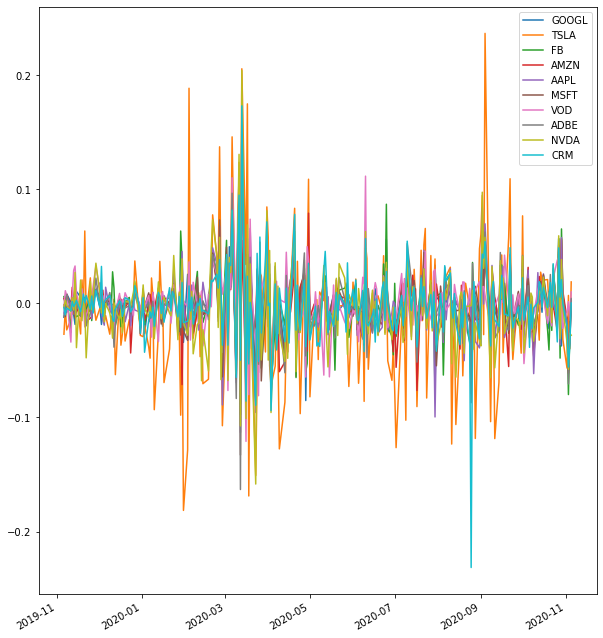

In [4]:
returns.plot(figsize = (10, 12))

In [5]:
returns.mean()

GOOGL   -0.001224
TSLA    -0.007448
FB      -0.001685
AMZN    -0.002419
AAPL    -0.002422
MSFT    -0.001740
VOD      0.001583
ADBE    -0.002146
NVDA    -0.004077
CRM     -0.001948
dtype: float64

In [6]:
returns.mean().mean()

-0.0023526909011353345

In [7]:
# the objective function is to minimize the portfolio risk
def objective(weights): 
    weights = np.array(weights)
    return weights.dot(returns.cov()).dot(weights.T)

In [8]:
# The constraints
cons = (# The weights must sum up to one.
        {"type":"eq", "fun": lambda x: np.sum(x)-1}, 
        # This constraints says that the inequalities (ineq) must be non-negative.
        # The expected daily return of our portfolio and we want to be at greater than 0.002352
        {"type": "ineq", "fun": lambda x: np.sum(returns.mean()*x)-0.003})

In [9]:
cons

({'type': 'eq', 'fun': <function __main__.<lambda>(x)>},
 {'type': 'ineq', 'fun': <function __main__.<lambda>(x)>})

In [11]:
# Every stock can get any weight from 0 to 1
bounds = tuple((0,1) for x in range(returns.shape[1]))
# Initialize the weights with an even split
# In out case each stock will have 10% at the beginning
guess = [1./returns.shape[1] for x in range(returns.shape[1])]
optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
optimized_results

     fun: 0.0007959499123098433
     jac: array([0.00083161, 0.0012308 , 0.0008373 , 0.00053939, 0.00084572,
       0.00092792, 0.0015919 , 0.00096136, 0.00114261, 0.00095905])
 message: 'Positive directional derivative for linesearch'
    nfev: 222
     nit: 15
    njev: 11
  status: 8
 success: False
       x: array([8.97190916e-19, 1.05978110e-18, 1.24870316e-12, 5.40067480e-19,
       1.43796012e-19, 3.82499857e-14, 1.00000000e+00, 5.03250510e-13,
       1.57305043e-13, 1.51795818e-13])

In [17]:
objective

<function __main__.objective(weights)>

In [51]:
optimized_results.x

array([8.97190916e-19, 1.05978110e-18, 1.24870316e-12, 5.40067480e-19,
       1.43796012e-19, 3.82499857e-14, 1.00000000e+00, 5.03250510e-13,
       1.57305043e-13, 1.51795818e-13])

In [47]:
# we get 1
np.sum(optimized_results.x)

1.0000000000020992

In [45]:
np.sum(returns.mean()*optimized_results.x)

0.0015827738108946468

In [18]:
# Final weights
pd.DataFrame(list(zip(symbols, optimized_results.x)), columns=['Symbol', 'Weight'])

,Symbol,Weight
0,GOOGL,8.971909e-19
1,TSLA,1.059781e-18
2,FB,1.248703e-12
3,AMZN,5.400675e-19
4,AAPL,1.437960e-19
5,MSFT,3.824999e-14
6,VOD,1.000000e+00
7,ADBE,5.032505e-13
8,NVDA,1.573050e-13
9,CRM,1.517958e-13
